In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import os
import virtual_biopsy_utils as vbu
import integration_images_features_utils as image_utils
import ast
import delong
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [30]:
def get_pretty_names_dict():
    return pd.read_csv('../assisting_docs/features_dictionary_.csv', index_col = 0, squeeze=True).to_dict()

In [29]:
# a = pd.read_csv('../assisting_docs/features_dictionary.csv', index_col = 0)
# a.loc['dx_V16.3_ind'] = ['Family history of BC']
# a.to_csv('../assisting_docs/features_dictionary_.csv')

### Load files ready to be trained

In [3]:
x_train = pkl.load(open('../pkls/x_train_ready_for_training_MALBEN.pkl', 'rb'))
y_train = pkl.load(open('../pkls/y_train_ready_for_training_MALBEN.pkl', 'rb'))

x_val = pkl.load(open('../pkls/x_val_ready_for_training_MALBEN.pkl', 'rb'))
y_val = pkl.load(open('../pkls/y_val_ready_for_training_MALBEN.pkl', 'rb'))


### Load shap features from cancer types

In [ ]:
shap_feats = pkl.load(open('../pkls/.pkl', 'rb'))

shap_feats = list(set(shap_feats))

In [ ]:
len(shap_feats)

### Drop features we dont use

In [4]:
imaging_feats = [x for x in x_train if 'pred' in x]

In [6]:
#if clinical only
feature_set = 'clinical'
x_train.drop(columns=  ['study_id']  + imaging_feats, inplace=True) 
x_val.drop(columns= ['study_id']  + imaging_feats, inplace=True)

# if shap only
# feature_set = 'shap'
# x_train = x_train [shap_feats]
# x_val = x_val [shap_feats]


# if shap + images
# feature_set = 'shap_and_predictions'
# imaging_feats = [x for x in x_train if 'pred' in x]
# x_train = x_train [imaging_feats + shap_feats]
# x_val = x_val [imaging_feats + shap_feats]


# if images only:
# feature_set = 'predictions'
# imaging_feats = [x for x in x_train if 'pred' in x]
# x_train = x_train[imaging_feats]
# x_val = x_val[imaging_feats]

In [7]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(1685, 1829) (357, 1829) (1685, 7) (357, 7)


### XGBoost

In [8]:
NUM_ITER = 10

In [9]:
# Make sure columns have the same order
x_val = x_val[x_train.columns]

In [10]:
classes = ['outcome_cancer_type_Malignant']

XGB = XGBClassifier( eval_metric = 'auc'
                   )

min_child_weight = [1, 2, 3, 5, 7]  
gamma= [0, 0.1, 0.2, 0.3, 0.4]
colsample_bytree= [0.3, 0.4, 0.5, 0.7, 1.0]
learning_rate= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50]  
max_depth= [3, 4, 5, 6, 7, 8, 10] 

     

grid_params_xgb = {'min_child_weight': min_child_weight,
                 'gamma': gamma,
                 'colsample_bytree': colsample_bytree,
                 'learning_rate': learning_rate,
                 'max_depth': max_depth}


XGB_CV= RandomizedSearchCV(estimator = XGB,
                 param_distributions = grid_params_xgb,
                 scoring = 'roc_auc', n_iter = 30,
                 cv=5 ) 


stats_runs = {}
stats_runs['AUC_mean'] = []
stats_runs['AUC_CI1'] = []
stats_runs['AUC_CI2'] = []
stats_runs['probabilities'] = []


for i in range(NUM_ITER):
    
    print ('{}/{}\r'.format(i+1, NUM_ITER), end = '', flush=True)

    for category in classes:

        print('**Processing class {} ...**'.format(category))
    
        XGB_CV.fit(x_train, y_train[category])
        y_pred = XGB_CV.predict(x_val)

        prob = XGB_CV.predict_proba(x_val)[:,1]
        stats_runs['AUC_mean'].append(roc_auc_score(y_val[category], 
                                        prob))
        stats_runs['AUC_CI1'].append(delong.get_delong_ci(prob, y_val[category])[0])
        stats_runs['AUC_CI2'].append(delong.get_delong_ci(prob, y_val[category])[1])                        
        stats_runs['probabilities'].append(prob)
        
        pkl.dump(XGB_CV.best_estimator_, 
open('../pkls/cancer_prediction_pkls/xgboost/' + str(feature_set) + '/model_' + str(category) + '_run_' + str(i) + '.pkl', 'wb')) 
        
        # SHAP

        best_params_grid_search = XGB_CV.best_params_

        model  = XGBClassifier(**best_params_grid_search)
        model.fit(x_train, y_train[category])
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(x_val)
        pkl.dump(shap_values, open('../pkls/cancer_prediction_pkls/xgboost/'+ str(feature_set) + '/shap_values_' + str(category) + '_run_' + str(i) + '.pkl', 'wb'))
 
    # Save probabilities
np.savetxt('significance_tests/MALBEN_predict_probs_XGBoost_' + str(feature_set) + '.csv', stats_runs['probabilities'], delimiter=',')

**Processing class outcome_cancer_type_Malignant ...**
**Processing class outcome_cancer_type_Malignant ...**
**Processing class outcome_cancer_type_Malignant ...**
**Processing class outcome_cancer_type_Malignant ...**
**Processing class outcome_cancer_type_Malignant ...**
**Processing class outcome_cancer_type_Malignant ...**
**Processing class outcome_cancer_type_Malignant ...**
**Processing class outcome_cancer_type_Malignant ...**
**Processing class outcome_cancer_type_Malignant ...**
**Processing class outcome_cancer_type_Malignant ...**


In [12]:
outputs = {'AUC_mean': stats_runs['AUC_mean'],
          'AUC_lowCI': stats_runs['AUC_CI1'],
          'AUC_highCI': stats_runs['AUC_CI2']}
df = pd.DataFrame(data=outputs)
df.to_csv('output_AUCs_all_models/MALBEN_' + str(feature_set) + '.csv')
df*100

,AUC_mean,AUC_lowCI,AUC_highCI
0,62.558923,56.151052,68.077904
1,65.156566,58.805719,70.618523
2,65.528620,59.226163,70.942187
3,65.811448,59.521473,71.212534
4,65.462963,59.090855,70.946182
5,64.436027,58.015208,69.967957
6,65.656566,59.320182,71.104061
7,65.175084,58.850094,70.611186
8,65.308081,58.955839,70.771434
9,65.811448,59.521473,71.212534


### SHAP

In [15]:
final_features_per_class = []

for category in classes:

    shap_values = []
    top_20_all_shap = []

    for i in range(10):
        shap_values.append(pkl.load(open('../pkls/cancer_prediction_pkls/xgboost/clinical/shap_values_' + str(category) + '_run_' + str(i) + '.pkl', 'rb')))
        top_20_all_shap.append(x_val.columns[np.argsort(np.abs(shap_values[i]).mean(0))].tolist()[::-1][:20])

    top_20_all_shap_flat = [item for sublist in top_20_all_shap for item in sublist]

    final_features_per_class.append(list(set([x for x in top_20_all_shap_flat if top_20_all_shap_flat.count(x) >=5 ])))

union_shap = list(set([item for sublist in final_features_per_class for item in sublist]))

with open('../pkls/sentara_union_shap_MALBEN.pkl', 'wb') as handle:
    pkl.dump(union_shap, handle, protocol=pkl.HIGHEST_PROTOCOL)


In [16]:
union_shap

['past_biopsy_proc_cnt',
 'labs_kidneys_levels_K+ Potassium (B)',
 'prev_benign_ind',
 'prev_benign_cnt',
 'age',
 'lump_by_dr_ind_current',
 'labs_blood_chem_levels_Ca-Calcium (B)_min',
 'complaint_ind_current',
 'months_since_first_MG',
 'menstruation_years',
 'children_cnt',
 'calc_breast_density_current',
 'pregnancies_cnt',
 'dx_V16.3_cnt',
 'calc_likelihood_obesity',
 'labs_cbc_levels_Hematocrit_min',
 'labs_cbc_levels_Platelets_min',
 'labs_blood_chem_levels_Ca-Calcium (B)_last',
 'past_biopsy_proc_ind',
 'labs_cbc_levels_Platelets']

### SHAP

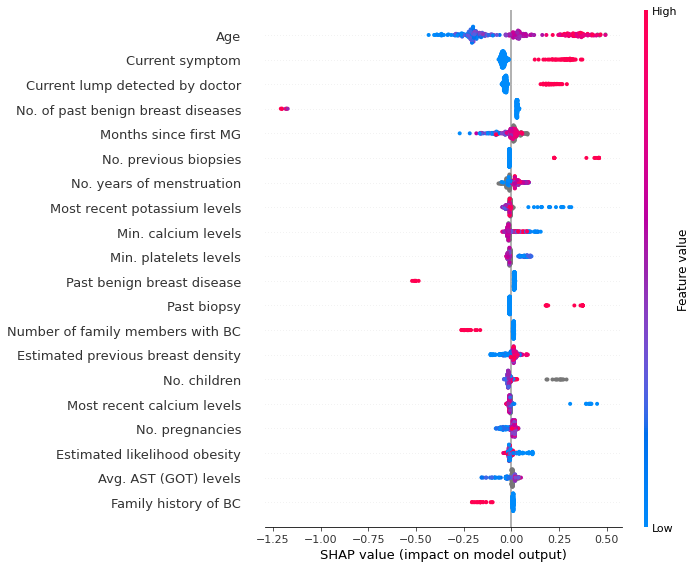

In [33]:
aucs = pd.read_csv('output_AUCs_all_models/MALBEN_clinical.csv', index_col =0) 
idx = aucs['AUC_mean'].argmax()
dcisshap = pkl.load(open('../pkls/cancer_prediction_pkls/xgboost/clinical/shap_values_outcome_cancer_type_Malignant_run_'+ str(idx)+'.pkl', 'rb'))
val_disp = x_val.rename(columns=get_pretty_names_dict())
shap.summary_plot(dcisshap, val_disp, max_display = 20, plot_type='dot', show = False)

plt.savefig("../RESULTS/Figures/shap_MALBEN_Maccabi_summary.eps", format="eps", dpi=600, bbox_inches="tight")
plt.savefig("../RESULTS/Figures/shap_MALBEN_Maccabi_summary.png", format="png", dpi=600, bbox_inches="tight")
plt.savefig("../RESULTS/Figures/shap_MALBEN_Maccabi_summary.pdf", format="pdf", dpi=600, bbox_inches="tight")